# Unsupervised Learning: Clustering Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.io import arff

import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from typing import List, Set

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 

Doing this here as it is used in the other classes

In [2]:
def silhouette(*, classes, data=None, dist_matrix=None):
    """
    Calulate silhouette score.
    Args:
        classes (array-like): 1-D array specifying the classes of `data`
        data (array-like): 2-D array specifying the data. 
                            If dist_matrix is not None, then `data` is ignored.
        dist_matrix (array-like): 2-D array specifying the distance between each point in `data`.
                            Does not need to be passed if `data` is passed.
    """
    if dist_matrix is None:
        dist_matrix = np.linalg.norm(data[:,None,:] - data[None,:,:], axis=-1)
    # Calculate average distance matrix
    np.fill_diagonal(dist_matrix, np.nan)
    avg_dist_matrix = np.array([np.nanmean(dist_matrix[classes==i], axis= 0) for i in np.unique(classes)]).T
    intra_dists = avg_dist_matrix[range(len(classes)), classes]
    avg_dist_matrix[range(len(classes)), classes] = np.inf
    nearest_dists = np.min(avg_dist_matrix, axis=1)
    point_scores = (nearest_dists - intra_dists) / np.maximum(nearest_dists, intra_dists)
    point_scores[np.isnan(point_scores)] = 0
    return np.average(point_scores)


## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- ~~HAC should support both single link and complete link options.~~
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- ~~The number of clusters (k).~~
- ~~The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)~~


For each cluster report include:


- ~~The centroid id.~~
- ~~The number of instances tied to that centroid.~~
 

In [3]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        self.clusters: List[List[np.array]] = []
        self.silhouette=0
        
    def fit(self, X, y=None, *, normalize=True):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        if normalize:
            X = (X - np.min(X, axis=0))/(np.max(X, axis=0) - np.min(X, axis=0))
            
        link_func = np.min if self.link_type == "single" else np.max
        used = np.inf if self.link_type == "single" else -np.inf
        
        dist_matrix = np.linalg.norm(X[None,:,:] - X[:,None,:], axis=-1)
        dist_matrix[dist_matrix==0] = used
        cluster_by_idx = [[i] for i in range(len(X))]
        
        for _ in range(len(X) - self.k):
            # Find distance between every combination of clusters
            cluster_dists = np.full((len(cluster_by_idx), len(cluster_by_idx)), np.inf)
            for i, cluster1 in enumerate(cluster_by_idx):
                for j, cluster2 in enumerate(cluster_by_idx[i+1:]):
                    j += i+1 #Makes sure indexes match up. Looped this way to not loop when i == j or i > j (duplicate distance)
                    relevant_dists = dist_matrix[cluster1,:][:, cluster2]
                    cluster_dists[i, j] = link_func(relevant_dists)
            # Find closest clusters
            c1_idx, c2_idx = np.unravel_index(np.argmin(cluster_dists), cluster_dists.shape)
            # Merge clusters
            cluster_by_idx[c1_idx] += cluster_by_idx.pop(c2_idx)
            
        labels = []
        for point in range(len(X)):
            for i, cluster in enumerate(cluster_by_idx):
                if point in cluster:
                    labels.append(i)
                    break
        self.silhouette = silhouette(data=X, classes=labels)
                    
                
        self.clusters = [np.array([X[idx] for idx in cluster]) for cluster in cluster_by_idx]
        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print(f"Num clusters: {len(self.clusters)}")
        print(f"Silhouette score: {self.silhouette}")
        for cluster in self.clusters:
            print(np.array2string(np.average(cluster, axis=0),precision=4,separator=","))
            print("{:d}\n".format(len(cluster)))

### 1.1.2 Debug 

Debug your model by running it on the [Debug Abalone Dataset](https://byu.instructure.com/courses/14142/files?preview=4735805)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.


- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.


---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735819)

[Debug HAC Complete (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735820)

In [4]:
def load_data(path, *, split=True, x_type=float, y_type=str):
    data, meta = arff.loadarff(path)
    data = np.array([[*row] for row in data])
    if split:
        X, y = data[:,:-1].astype(x_type), data[:,-1].astype(y_type)
    else:
        X, y = data.astype(x_type), None
    return X, y
    

In [5]:
# Debug Here
X, y = load_data("data/abalone.arff", split=False)

hac = HACClustering(5, "single")
hac.fit(X)
hac.print_clusters()

Num clusters: 5
Silhouette score: 0.34525948566983433
[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1



/tmp/ipykernel_74162/843845863.py:15: RuntimeWarning: Mean of empty slice
  avg_dist_matrix = np.array([np.nanmean(dist_matrix[classes==i], axis= 0) for i in np.unique(classes)]).T


### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Seismic-bumps_train Dataset](https://byu.instructure.com/courses/14142/files?preview=4735829)

- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

#### 1.1.3.1 Complete Link

In [6]:
# Load evaluation data
X, y = load_data("data/seismic-bumps_train.arff")
# Train on evaluation data using complete link
hac = HACClustering(k=5, link_type='single')
hac.fit(X)
# Print clusters
hac.print_clusters()

Num clusters: 5
Silhouette score: -0.12186295921454993
[0.5173,0.5639,0.5388,0.528 ,0.519 ,0.3946,0.5163]
136

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ]
1

[0.795 ,0.8615,0.4172,0.7654,0.7498,0.9995,0.7553]
1



/tmp/ipykernel_74162/843845863.py:15: RuntimeWarning: Mean of empty slice
  avg_dist_matrix = np.array([np.nanmean(dist_matrix[classes==i], axis= 0) for i in np.unique(classes)]).T


#### 1.1.3.1 Single Link

In [7]:
# Load evaluation data
X, y = load_data("data/seismic-bumps_train.arff")
# Train on evaluation data using complete link
hac = HACClustering(k=5, link_type='single')
hac.fit(X)
# Print clusters
hac.print_clusters()

Num clusters: 5
Silhouette score: -0.12186295921454993
[0.5173,0.5639,0.5388,0.528 ,0.519 ,0.3946,0.5163]
136

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ]
1

[0.795 ,0.8615,0.4172,0.7654,0.7498,0.9995,0.7553]
1



/tmp/ipykernel_74162/843845863.py:15: RuntimeWarning: Mean of empty slice
  avg_dist_matrix = np.array([np.nanmean(dist_matrix[classes==i], axis= 0) for i in np.unique(classes)]).T


### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---
You only need to handle continuous features

In [8]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False, normalize=True): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.normalize = normalize
        self.centroids = None
        self.centroid_sizes = None
        self.silhouette = 0
        
        self.X = None
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need classes
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.X = X
        if self.normalize:
            X = (X - np.min(X, axis=0))/(np.max(X, axis=0) - np.min(X, axis=0))
        centroids = X[np.random.choice(range(len(X)), self.k)] if not self.debug else X[:self.k].copy()
        centroid_sizes = np.zeros((self.k,)).astype(int)
        prev_centroids = np.full_like(centroids, np.nan)
        
        c = 0
        while np.any(centroids != prev_centroids):
            prev_centroids = centroids.copy()
            centroid_dists = np.linalg.norm(centroids[:,None,:] - X[None,:,:], axis=-1).T
            classes = np.argmin(centroid_dists, axis=1)
            for i in range(len(centroids)):
                if np.any(classes==i):
                    centroids[i] = np.average(X[classes==i], axis=0)
                centroid_sizes[i] = np.sum(classes==i)
            c+=1
                
        # Calculate silhouette score
        self.silhouette = silhouette(data=X, classes=classes)
               
        self.centroids = centroids
        self.centroid_sizes = centroid_sizes
        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}".format(self.k))
        print("Silhouette score: {:.4f}\n".format(self.silhouette))
        dist_matrix = np.sum((self.centroids[:, None, :] - self.X[None, :, :])**2, axis=2)**.5
        classes = np.argmin(dist_matrix, axis=0)
        for i, (centroid, size) in enumerate(zip(self.centroids, self.centroid_sizes)):
            print(np.array2string(centroid,precision=4,separator=","))
            print("{:d}\n".format(size))

### 1.2.2 Debug 

Debug your model by running it on the [Debug Abalone Dataset](https://byu.instructure.com/courses/14142/files?preview=4735805)


- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values




---
Solutions in files:

[Debug K Means (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735840)

In [9]:
# Load debug data
X, y = load_data("data/abalone.arff", split=False)
X

# Train on debug data
kmns = KMEANSClustering(k=5, debug=True)
kmns.fit(X)
kmns.print_clusters()

# Print clusters

Num clusters: 5
Silhouette score: 0.3845

[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13



### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Seismic-bumps_train Dataset](https://byu.instructure.com/courses/14142/files?preview=4735829)
- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

In [10]:
# Load evaluation data
X, y = load_data("data/seismic-bumps_train.arff")

# Train on evaluation data
kmns = KMEANSClustering(k=5, debug=True)
kmns.fit(X)

# Print clusters
kmns.print_clusters()

Num clusters: 5
Silhouette score: 0.2587

[0.5309,0.6006,0.439 ,0.5735,0.5103,0.5342,0.6215]
25

[0.3461,0.4113,0.4303,0.4128,0.3384,0.2791,0.3367]
27

[0.3908,0.4086,0.7787,0.319 ,0.4958,0.3748,0.2679]
19

[0.1698,0.2172,0.4256,0.2178,0.1689,0.318 ,0.172 ]
21

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919]
48



## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

Num clusters: 2
Silhouette score: 0.6294675561906643
[0.1961,0.5908,0.0786,0.06  ]
50

[0.545 ,0.3633,0.662 ,0.6567]
100

----------------------------------------


/tmp/ipykernel_74162/843845863.py:15: RuntimeWarning: Mean of empty slice
  avg_dist_matrix = np.array([np.nanmean(dist_matrix[classes==i], axis= 0) for i in np.unique(classes)]).T


Num clusters: 3
Silhouette score: 0.530889323901593
[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.545 ,0.3633,0.662 ,0.6567]
100

----------------------------------------
Num clusters: 4
Silhouette score: 0.3882664409102069
[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5363,0.3554,0.6563,0.6531]
98

[0.9722,0.75  ,0.9407,0.8333]
2

----------------------------------------
Num clusters: 5
Silhouette score: 0.20510173993234454
[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5401,0.357 ,0.657 ,0.6529]
97

[0.1667,0.2083,0.5932,0.6667]
1

[0.9722,0.75  ,0.9407,0.8333]
2

----------------------------------------
Num clusters: 6
Silhouette score: 0.16046278106948017
[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5373,0.3537,0.6548,0.6493]
96

[0.1667,0.2083,0.5932,0.6667]
1

[0.8056,0.6667,0.8644,1.    ]
1

[0.9722,0.75  ,0.9407,0.8333]
2

----------------------------------------
Num clusters: 7
Silh

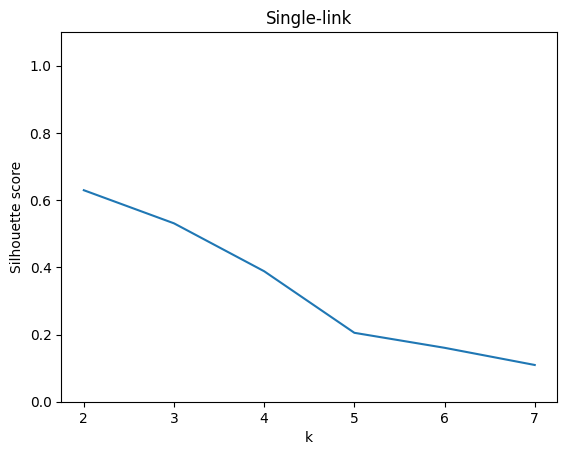

In [11]:
# Iris Classification using single-link
# Load evaluation data
iris, y = load_data("data/iris.arff", y_type=str)
# print(X.shape)
# print(y.shape)
# Train on evaluation data using complete link
scores = []
for k in range(2,8):
    hac = HACClustering(k=k, link_type='single')
    hac.fit(iris)
    # Print clusters
    hac.print_clusters()
    scores.append(hac.silhouette)
    print('-'*40)
    
plt.plot(range(2,8), scores)
plt.title("Single link")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.ylim(ymin=0, ymax=1.1)
plt.title("Single-link")
plt.show()

In [ ]:
# Iris Classification using single-link
scores = []
for k in range(2,8):
    hac = HACClustering(k=k, link_type='complete')
    hac.fit(iris)
    # Print clusters
    hac.print_clusters()
    scores.append(hac.silhouette)
    print('-'*40)
    
plt.plot(range(2,8), scores)
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.ylim(ymin=0, ymax=1.1)
plt.title("Complete-link")
plt.show()

Num clusters: 2
Silhouette score: 0.30391309058110383
[0.3436,0.4318,0.367 ,0.3452]
116

[0.719 ,0.4645,0.8106,0.8419]
34

----------------------------------------
Num clusters: 3
Silhouette score: 0.5030674466509139
[0.1961,0.5908,0.0786,0.06  ]
50

[0.4554,0.3112,0.5855,0.5612]
66

[0.719 ,0.4645,0.8106,0.8419]
34

----------------------------------------


**Discuss differences between single-link and complete-link**

To sum up in one sentence, the single link had a higher silhouette score for the best-case scenario, but the complete-link was more consistent. <br>
<br>
It seems like the single-link clearly favored a lower `k`, as it had a pretty good silhouette score for `k=2` (.62) and `k=3` (.57). However, after that it dipped very low. On the other hand, the silhouette score for the complete link peaked at `k=3` (.51), but always stayed within the range of about .3 to .51. I think that this is because the single link can classfy better between two or three groups, as the few groups are more distinct and the clustering is not as impeded by a variety of options. On the other hand, the complete link performed about as well for everything since it based its decision-- in a very loose, non-exact sense-- on the more extreme elements of the group. 

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

In [ ]:
X, y = load_data("data/iris.arff", y_type=str)
labels = y.copy()
y = np.array([(y == val).astype(int) for val in np.unique(y)]).T
iris_w_output = np.append(X, y, axis=1)
iris_w_output

In [ ]:
# Clustering labels with single-link
# Load evaluation data
scores = []
for k in range(2,8):
    hac = HACClustering(k=k, link_type='single')
    hac.fit(iris_w_output)
    # Print clusters
    hac.print_clusters()
    scores.append(hac.silhouette)
    print('-'*40)
    
plt.plot(range(2,8), scores)
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.ylim(ymin=0, ymax=1.1)
plt.title("Single-link with output")
plt.show()

In [ ]:
# Clustering labels with complete-link
# Load evaluation data
scores = []
for k in range(2,8):
    hac = HACClustering(k=k, link_type='complete')
    hac.fit(iris_w_output)
    # Print clusters
    hac.print_clusters()
    scores.append(hac.silhouette)
    print('-'*40)
    
plt.plot(range(2,8), scores)
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.ylim(ymin=0, ymax=1.1)
plt.title("Complete-link with output")
plt.show()

**Discuss any differences between the results from 2.1.1 and 2.1.2.**<br>
When running the data with the output labels, it drastically improved the scores. In addition, both single link and complete link scored very similarly for all values of `k`. My guess is because including the output labels added a whole new dimension (or three due to one-hot encoding) that helped drastically separate out the data. This is supported by the fact that the optimal value for `k` for both single and complete link was 3, which was the original number of classes.

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

In [ ]:
# Clustering labels without output as feature
# Load evaluation data
scores = []
for k in range(2,8):
    kmns = KMEANSClustering(k=k)
    kmns.fit(iris)
    # Print clusters
    kmns.print_clusters()
    scores.append(kmns.silhouette)
    print('-'*40)
    
plt.plot(range(2,8), scores)
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.ylim(ymin=0, ymax=1.1)
plt.title("K-Means without output")
plt.show()

In [ ]:
# Clustering labels with output as feature
# Load evaluation data
scores = []
for k in range(2,8):
    kmns = KMEANSClustering(k=k)
    kmns.fit(iris_w_output)
    # Print clusters
    kmns.print_clusters()
    scores.append(kmns.silhouette)
    print('-'*40)
    
plt.plot(range(2,8), scores)
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.ylim(ymin=0, ymax=1.1)
plt.title("K-Means with output")
plt.show()

**Compare results and differences between using the output label and excluding the output label**<br>
Much like the HAC problems, the KMeans classification did much better when provided the output label. It did much better when `k=3`, the original number of output classes, and stayed pretty  constant otherwise. If not given the output classes, the algorithm definately favored smaller values of `k` with one notable exception: `k=6`. I'm not sure what to make of it; I would guess that the algorithm found something that really helped split each of the groups in half, or something similar to that. I find it very strange that there was a peak at exactly 2 times the normal output class.

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

In [ ]:
#K-Means 5 times
for i in range(5):
    print(f"ITERATION {i+1}")
    kmns = KMEANSClustering(k=4)
    kmns.fit(X)

    # Print clusters
    kmns.print_clusters()
    print('-'*40)

**Discuss any variations in the results**<br>
The silhouette scores did not vary much. I found this interesting, as I figured the random choice would significantly impact the variation. However, it seems like the data is sufficiently separated that when I run the kmeans clustering without any limit of iterations, it usually arrives at the same result every time.

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

In [ ]:
# Load sklearn
import itertools as it
from sklearn.metrics import silhouette_score, completeness_score, adjusted_mutual_info_score
metrics = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2']
linkages = ['ward', 'complete', 'average', 'single']

args_list = [{'metric': metric,  'linkage': linkage} for metric, linkage in it.product(metrics, linkages) ]
# args_strings = [' | '.join([f"{arg}={val}" for arg, val in args.items()]) for arg in args_list]

int_labels = np.unique(labels, return_inverse=True)[1]

silhouette= []
completeness = []
adjusted_mututal_info = []
remove_args = []
for i, args in enumerate(args_list):
    if args['linkage'] == 'ward' and args['metric'] != 'euclidean':
        remove_args.append(i)
        continue
    sil_i = []
    comp_i = []
    adj_i = []
    for k in range(2,8):
        args['n_clusters'] = k
        hac = AgglomerativeClustering(**args)
        predicted_labels = hac.fit_predict(iris_w_output)

        sil_i.append(silhouette_score(iris_w_output, predicted_labels, metric=args['metric']))
        comp_i.append(completeness_score(int_labels, predicted_labels))
        adj_i.append(adjusted_mutual_info_score(int_labels, predicted_labels))
        del args['n_clusters']
    
    silhouette.append(tuple(sil_i))
    completeness.append(tuple(comp_i))
    adjusted_mututal_info.append(tuple(adj_i))

args_list = [arg for i, arg in enumerate(args_list) if i not in remove_args]
args_strings = [str(arg) for arg in args_list]
for score_name, scores in zip(("Silhouette", "Completeness", "Adjusted Mutual Info"), (silhouette, completeness, adjusted_mututal_info)):
    plt.figure(figsize=(30,20))
    for s_i in scores:
        plt.plot(range(2,8), s_i, label=True, linewidth=4)
    
    plt.legend(args_strings, fontsize=20,loc="lower center", ncol=2)
    plt.title(f"{score_name} score", fontweight='bold')
    plt.xlabel('k')
    plt.ylim(ymin=0, ymax=1.1)
    plt.xlim(xmin=2, xmax=7)
    plt.show()


**Record impressions**<br>
The combination of hyperparameters that consistently performed among the best was `metric=cosine, linkage=single`. All other top-level combinations always seemed to fail in at least one other respect. For instance, argument pairs such as `euclidean, ward` and `l1, complete` did very well with the completeness score and adjusted mutual info score, but did worse for the silhouette score. This made me wonder how one would select  the best scoring metric: there seems to be a lot of variation! However, the one nice thing is that all of the hyperparameter combinations made the scores follow a similar pattern, so as long as you stuck to one, you would be able to appropriately compare scores at least.
<br><br>
What I found bizzare is that the `cosine` distance metrics did so well. Not sure how this makes a difference, but it is definately something to look into.<br><br>
Also, sorry that the colors looped; I couldn't figure out how to get matplotlib to stop doing that in the time I had. :/

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

In [ ]:
# Load sklearn
inits = ['k-means++', 'random']
n_inits = [5, 10, 20]
max_iters = [100, 300, 600]
algorithms = ['lloyd', 'elkan']

args_list = [{'init': init, 'n_init': n_init, 'max_iter': max_iter, 'algorithm': algorithm} 
             for init, n_init, max_iter, algorithm in it.product(inits, n_inits, max_iters, algorithms)]
# args_strings = [' | '.join([f"{arg}={val}" for arg, val in args.items()]) for arg in args_list]
args_strings = [str(arg) for arg in args_list]

int_labels = np.unique(labels, return_inverse=True)[1]

silhouette= []
completeness = []
adjusted_mututal_info = []
for args in args_list:
    sil_i = []
    comp_i = []
    adj_i = []
    for k in range(2,8):
        args['n_clusters'] = k
        kmeans = KMeans(**args)
        predicted_labels = kmeans.fit_predict(iris_w_output)

        sil_i.append(silhouette_score(iris_w_output, predicted_labels))
        comp_i.append(completeness_score(int_labels, predicted_labels))
        adj_i.append(adjusted_mutual_info_score(int_labels, predicted_labels))
        del args['n_clusters']
    
    silhouette.append(tuple(sil_i))
    completeness.append(tuple(comp_i))
    adjusted_mututal_info.append(tuple(adj_i))

for score_name, scores in zip(("Silhouette", "Completeness", "Adjusted Mutual Info"), (silhouette, completeness, adjusted_mututal_info)):
    plt.figure(figsize=(30,20))
    for s_i in scores:
        plt.plot(range(2,8), s_i, label=True, linewidth=4)
    
    plt.legend(args_strings, fontsize=15, loc="lower center", ncol=3)
    plt.title(f"{score_name} score", fontweight='bold')
    plt.xlabel('k')
    plt.ylim(ymin=0, ymax=1.1)
    plt.xlim(xmin=2, xmax=7)
    plt.show()

**Record impressions**<br><br>
Unlike the HAC, All of the different hyperparameters seemed to perform fairly similarly. There was a peak around `k=3` (though not for `silhouette` strangely enough; still scored highly), then decreased. This follows a similar pattern to that seen in section 2.2. This makes sense, as the output label was included. When I didn't include the labels (below), The pattern also followed the same as above, sitting at a max early on and tapering off. Interestingly though, the Adjusted Mutual info score did show a peak around 3

In [ ]:
# Load sklearn
inits = ['k-means++', 'random']
n_inits = [5, 10, 20]
max_iters = [100, 300, 600]
algorithms = ['lloyd', 'elkan']

args_list = [{'init': init, 'n_init': n_init, 'max_iter': max_iter, 'algorithm': algorithm} 
             for init, n_init, max_iter, algorithm in it.product(inits, n_inits, max_iters, algorithms)]
# args_strings = [' | '.join([f"{arg}={val}" for arg, val in args.items()]) for arg in args_list]
args_strings = [str(arg) for arg in args_list]

int_labels = np.unique(labels, return_inverse=True)[1]

silhouette= []
completeness = []
adjusted_mututal_info = []
for args in args_list:
    sil_i = []
    comp_i = []
    adj_i = []
    for k in range(2,8):
        args['n_clusters'] = k
        kmeans = KMeans(**args)
        predicted_labels = kmeans.fit_predict(iris)

        sil_i.append(silhouette_score(iris, predicted_labels))
        comp_i.append(completeness_score(int_labels, predicted_labels))
        adj_i.append(adjusted_mutual_info_score(int_labels, predicted_labels))
        del args['n_clusters']
    
    silhouette.append(tuple(sil_i))
    completeness.append(tuple(comp_i))
    adjusted_mututal_info.append(tuple(adj_i))

for score_name, scores in zip(("Silhouette", "Completeness", "Adjusted Mutual Info"), (silhouette, completeness, adjusted_mututal_info)):
    plt.figure(figsize=(30,20))
    for s_i in scores:
        plt.plot(range(2,8), s_i, label=True, linewidth=4)
    
    plt.legend(args_strings, fontsize=15, loc="lower center", ncol=3)
    plt.title(f"{score_name} score", fontweight='bold')
    plt.xlabel('k')
    plt.ylim(ymin=0, ymax=1.1)
    plt.xlim(xmin=2, xmax=7)
    plt.show()

In [ ]:
# Copy function Below